In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from ravenclaw.wrangling import standardize_columns
from divination.nn import CNN, TextDataset
from torch.utils.data import DataLoader
from pensieve import ComputationGraph

In [2]:
cg = ComputationGraph()
cg.add(
    name='raw_sentiment', parents=[], 
    function=lambda: pd.read_csv('data/Raw_Sentiment_Output_10000_tweets.csv')
)
cg.add(
    name='clean_sentiment', parents=['raw_sentiment'], 
    function=lambda x: standardize_columns(x.drop(columns=x.columns[0]))
)
cg.add(
    name='tweet_texts', parents=[], 
    function=lambda: pd.read_csv('data/SentimentOutput_10000_tweets.csv')[['tweet_id', 'tweet_text']].drop_duplicates()
)
cg.add(
    name='training_and_test', parents=['tweet_texts'],
    function=lambda x: train_test_split(x, test_size=0.2)
)
cg.add(name='training', parents=['training_and_test'], function=lambda x: x[0])
cg.add(name='test', parents=['training_and_test'], function=lambda x: x[1])
for name in ['training', 'test']:  
    cg.add(
        name=f'{name}_tweet_sentiment_with_nan', parents=[name, 'clean_sentiment'],
        function=lambda x: x['clean_sentiment'].merge(right=x[name], on='tweet_id', how='inner')
    )
    cg.add(
        name=f'{name}_df', parents=[f'{name}_tweet_sentiment_with_nan'],
        function=lambda x: x[x['sentiment_score'].notnull()].reset_index(drop=True)
    )



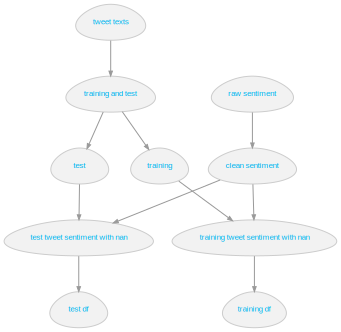

In [3]:
cg.render()

In [4]:
cg['training_df'].head(3)
training_df = cg['training_df']
test_df = cg['test_df']

In [5]:
import torch


In [6]:
BATCH_SIZE = 64
DEVICE = torch.device('cpu')

In [7]:
cnn = CNN(text=training_df['tweet_text'])

🕔 e:33.4s   r: 0.0s   ▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅ 100.00% WE word vector embedding ready!


In [8]:
training_df.head(2)

tweet_id  instance_id  iteration_id       worker_id keyword  \
0  1011659852924571648       128282        382168  A15S3KI5TD7MBF    citi   
1  1011659852924571648       128282        382171  A282UVFL2R927S    citi   

   keyword_irrelevant_flag  sentiment_score  \
0                    False              2.0   
1                    False              2.0   

                                          tweet_text  
0  #ValkyrieProud of Sydney Flynn, SHA Class of 2...  
1  #ValkyrieProud of Sydney Flynn, SHA Class of 2...

In [9]:
training_set = TextDataset(x=training_df['tweet_text'], y=training_df['sentiment_score'], vectorizer=cnn.embedding.vectorizer)
test_set = TextDataset(x=test_df['tweet_text'], y=test_df['sentiment_score'], vectorizer=cnn.embedding.vectorizer)

In [10]:
training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [22]:
test_batch = next(iter(training_loader))
test_batch['X'][0]

tensor([[    1.,     3.,     4.,  ...,     0.,     0.,     0.],
        [    1.,     3.,     4.,  ...,     0.,     0.,     0.],
        [    1.,    11.,    12.,  ...,     0.,     0.,     0.],
        ...,
        [    1.,  6071., 19438.,  ...,     0.,     0.,     0.],
        [    1.,  6071., 19438.,  ...,     0.,     0.,     0.],
        [    1.,  6071., 19438.,  ...,     0.,     0.,     0.]])

In [24]:
cnn.embedding(test_batch['X'])

RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got CPUFloatTensor instead (while checking arguments for embedding)

In [12]:
y = torch.randn(5, 10, 15)

In [14]:
y.size()

torch.Size([5, 10, 15])

In [21]:
y.view(5,-1).size()

torch.Size([5, 150])

In [11]:
cnn.train_and_evaluate(training_iterator=training_loader, validation_iterator=test_loader, device=DEVICE, num_epochs=5)

CN epoch 1
🕐 e: 1.1s   r:        ▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅   0.00% CN training with loss:0, accuracy:0torch.Size([64, 38955, 98])


RuntimeError: number of dims don't match in permute

In [ ]:
test_batch = next(iter(dataloader))
test_batch['X'].size()

In [ ]:
test_batch['y'].size()

In [ ]:
v = cnn.embedding.vectorizer

In [ ]:
x = v.transform(x=training_tweet['text'])

In [ ]:
type(x)


In [ ]:
training_tensor = v.transform(training_tweet['text'])
test_tensor = v.transform(test_tweet['text'])

In [ ]:
from torchtext import data

In [ ]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (training_tensor, test_tensor, test_tensor), 
    batch_size=BATCH_SIZE, 
    device=device)